In [36]:
import sys
from pathlib import Path
import re
def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/zohra/mlfs-book
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [37]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [38]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)

2025-11-17 16:11:27,230 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-17 16:11:27,235 INFO: Initializing external client
2025-11-17 16:11:27,238 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-17 16:11:28,931 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279126


In [39]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality_per_city',
    version=2,
)
weather_fg = fs.get_feature_group(
    name='weather_spain',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [40]:
# Select features for training data.
selected_features = (
    air_quality_fg
    .select(['pm25', 'date', 'rolling_mean', 'city', 'street'])
    .join(
        weather_fg.select_features(),
        on=['city']
    )
)


2025-11-17 16:11:31,399 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather_spain` as features for the query. To include primary key and event time use `select_all`.


In [41]:
#selecte
d_features_df = weather_fg.read().sort_values("date")
selected_features_df=selected_features.read().sort_values("date")

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.96s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.39s) 


In [42]:
air_quality_df = air_quality_fg.read().sort_values("date")

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.03s) 


In [43]:
weather_df = weather_fg.read().sort_values("date")

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.13s) 


### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [44]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")
test_start = pd.Timestamp(test_start, tz="UTC")
test_start
streets = selected_features_df["street"].unique()
print(streets)
selected_features.filter(air_quality_fg.street == "barcelona").read()

['barcelona-gracia-st.gervasi' 'barcelona-parc-vall-dhebron' 'barcelona'
 'barcelona-eixample' 'barcelona-palau-reial' 'barcelona-poblenou']
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.24s) 


,pm25,date,rolling_mean,city,street,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,34.0,2021-11-13 00:00:00+00:00,23.666666,catalunya,barcelona,8.604918,0.0,15.158522,272.634125
1,42.0,2021-11-14 00:00:00+00:00,27.333334,catalunya,barcelona,7.975750,0.1,15.893093,279.950562
2,36.0,2021-11-15 00:00:00+00:00,34.333332,catalunya,barcelona,7.390335,0.5,24.798225,282.431519
3,38.0,2021-11-16 00:00:00+00:00,37.333332,catalunya,barcelona,5.398667,1.5,16.657539,276.321747
4,38.0,2021-11-17 00:00:00+00:00,38.666668,catalunya,barcelona,4.577833,0.0,22.392462,267.262177
...,...,...,...,...,...,...,...,...,...
1336,40.0,2025-11-12 00:00:00+00:00,23.333334,catalunya,barcelona,10.436168,0.0,11.177405,114.405510
1337,48.0,2025-11-13 00:00:00+00:00,31.666666,catalunya,barcelona,12.119500,0.0,21.293324,90.114731
1338,55.0,2025-11-14 00:00:00+00:00,40.000000,catalunya,barcelona,11.629916,3.6,12.825552,93.058044
1339,17.0,2025-11-16 00:00:00+00:00,33.000000,catalunya,barcelona,13.650000,0.0,17.673029,266.496521


In [45]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

=== STREET: barcelona-gracia-st.gervasi ===
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1.0}
MSE: 160.21594
R2: 0.35591249736635067


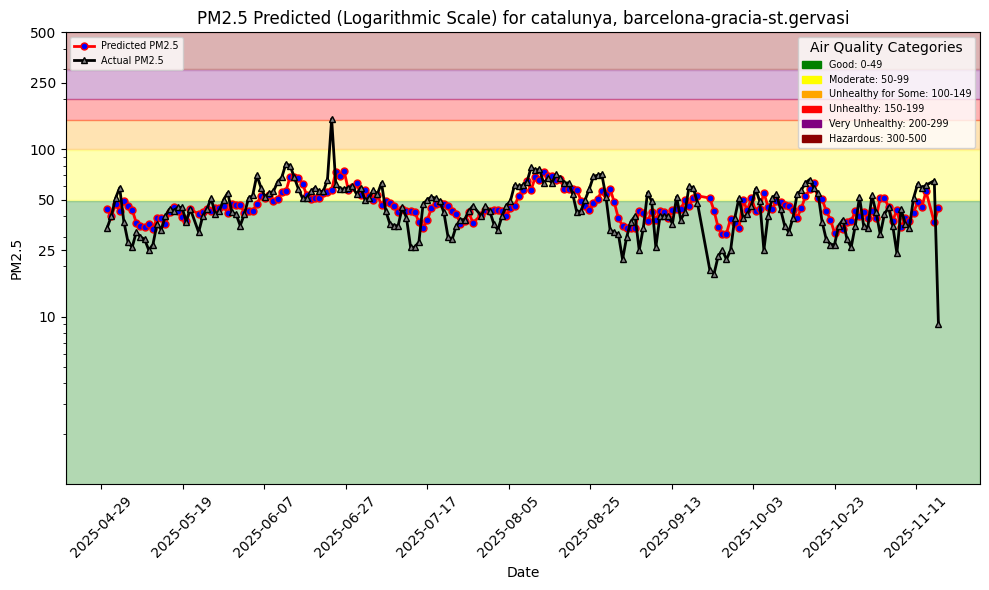

<Figure size 800x600 with 0 Axes>

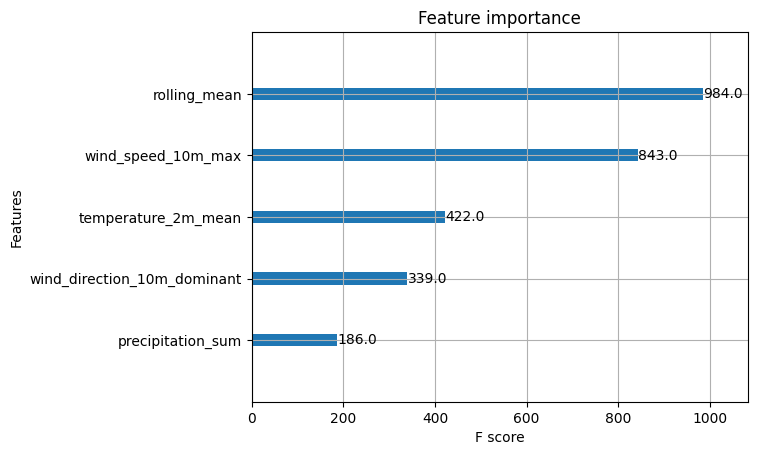

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_poblenou.json: 0.000%| …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_v2.json: 0.000%|          | 0/443…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_parc_vall_dhebron.json:…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model.json: 0.000%|          | 0/452516…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_gracia_st_gervasi.json:…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_palau_reial.json: 0.000…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona.json: 0.000%|          …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_eixample.json: 0.000%| …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_eix…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_pal…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_gra…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_poblenou…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_palau_re…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance.png: 0.000%| …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_gracia_s…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_v2.png: 0.000…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_par…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_pob…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast.png: 0.000%|      …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona.png…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_parc_val…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona.png: 0.0…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_eixample…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_v2.png: 0.000%|   …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279126/models/air_quality_xgboost_barcelona_gracia_st_gervasi/13
=== STREET: barcelona-parc-vall-dhebron ===
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1.0}
MSE: 122.870964
R2: 0.46857691512369226


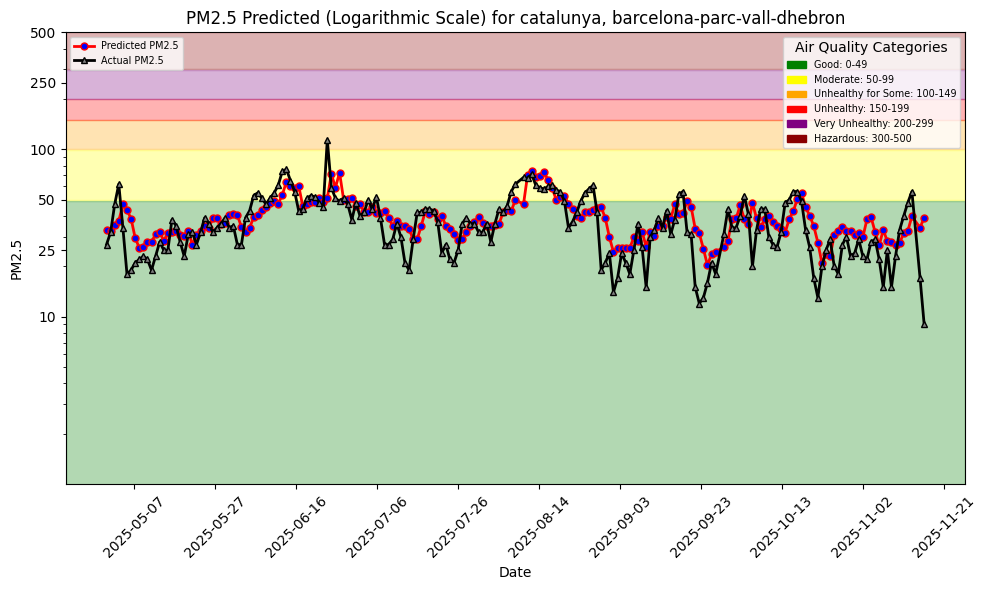

<Figure size 800x600 with 0 Axes>

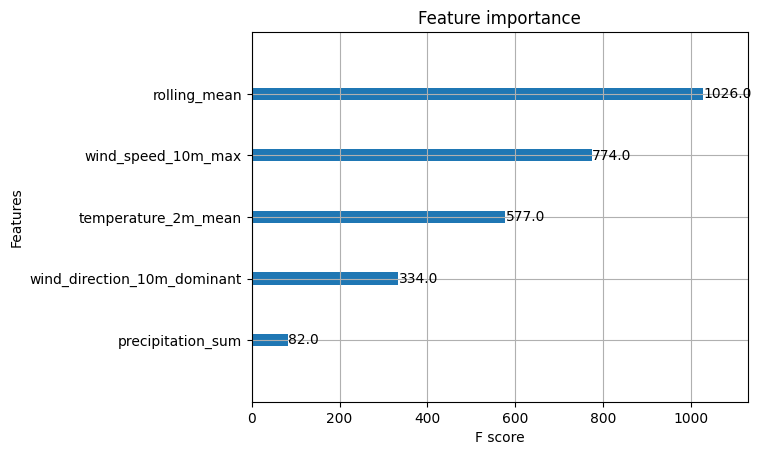

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_poblenou.json: 0.000%| …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_v2.json: 0.000%|          | 0/443…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_parc_vall_dhebron.json:…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model.json: 0.000%|          | 0/452516…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_gracia_st_gervasi.json:…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_palau_reial.json: 0.000…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona.json: 0.000%|          …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_eixample.json: 0.000%| …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_eix…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_pal…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_gra…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_poblenou…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_palau_re…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance.png: 0.000%| …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_gracia_s…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_v2.png: 0.000…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_par…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_pob…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast.png: 0.000%|      …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona.png…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_parc_val…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona.png: 0.0…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_eixample…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_v2.png: 0.000%|   …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279126/models/air_quality_xgboost_barcelona_parc_vall_dhebron/13
=== STREET: barcelona ===
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1.0}
MSE: 124.68721
R2: 0.4555831745744634


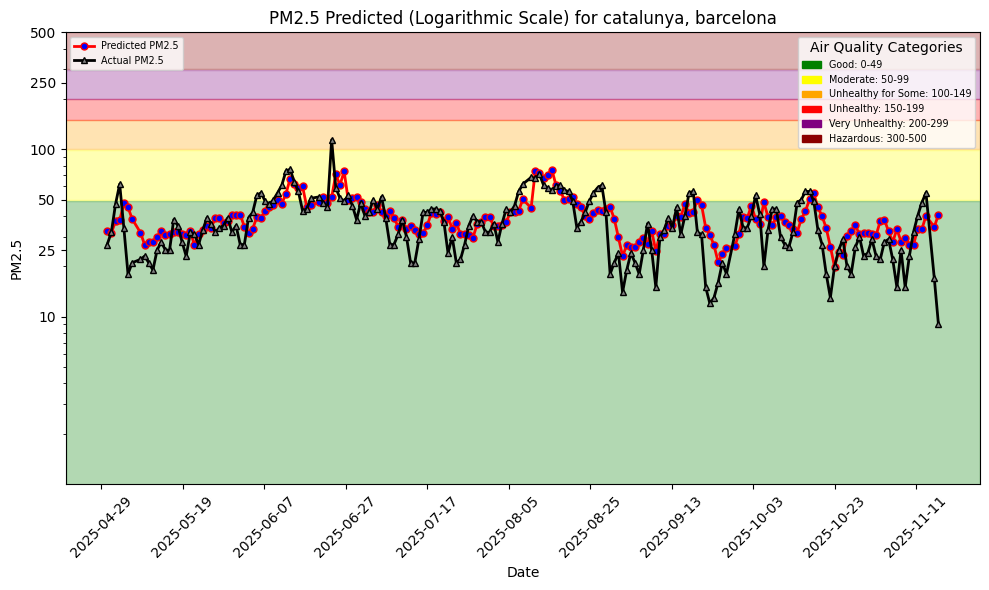

<Figure size 800x600 with 0 Axes>

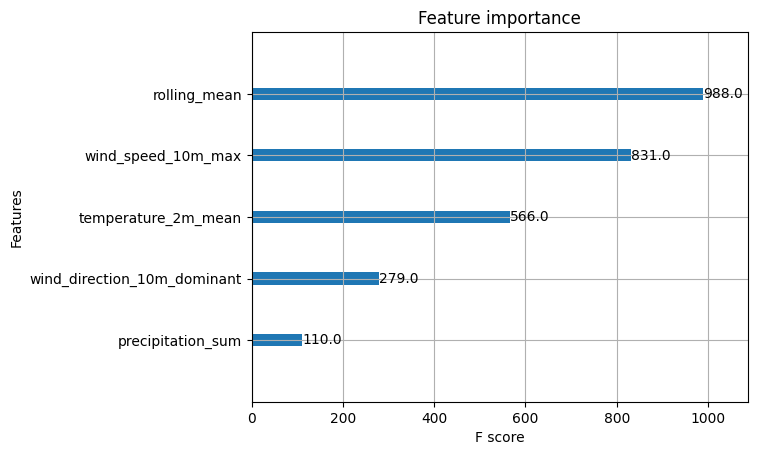

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_poblenou.json: 0.000%| …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_v2.json: 0.000%|          | 0/443…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_parc_vall_dhebron.json:…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model.json: 0.000%|          | 0/452516…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_gracia_st_gervasi.json:…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_palau_reial.json: 0.000…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona.json: 0.000%|          …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_eixample.json: 0.000%| …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_eix…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_pal…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_gra…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_poblenou…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_palau_re…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance.png: 0.000%| …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_gracia_s…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_v2.png: 0.000…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_par…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_pob…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast.png: 0.000%|      …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona.png…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_parc_val…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona.png: 0.0…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_eixample…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_v2.png: 0.000%|   …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279126/models/air_quality_xgboost_barcelona/13
=== STREET: barcelona-eixample ===
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1.0}
MSE: 155.58742
R2: 0.35778939942743493


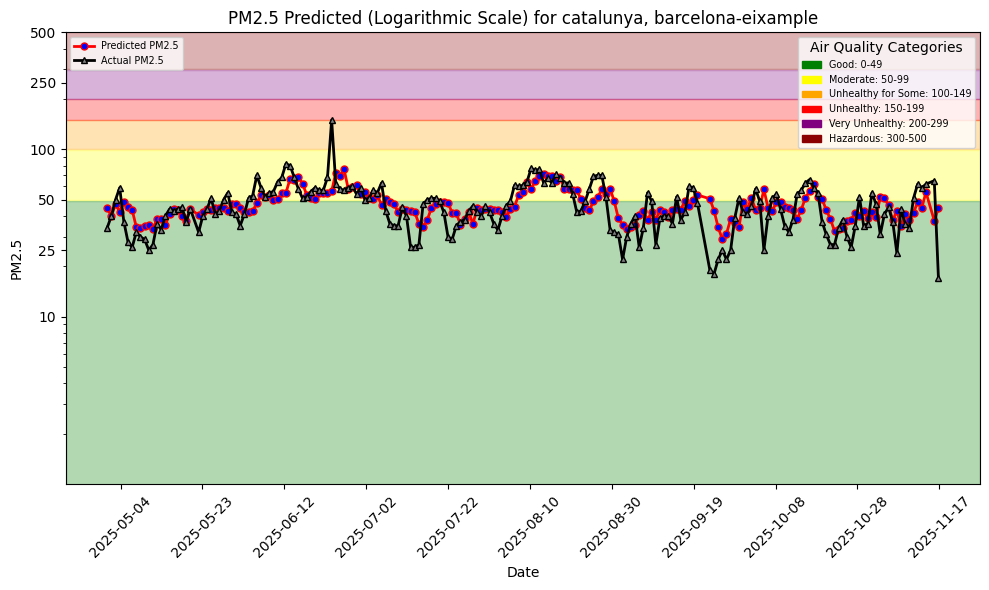

<Figure size 800x600 with 0 Axes>

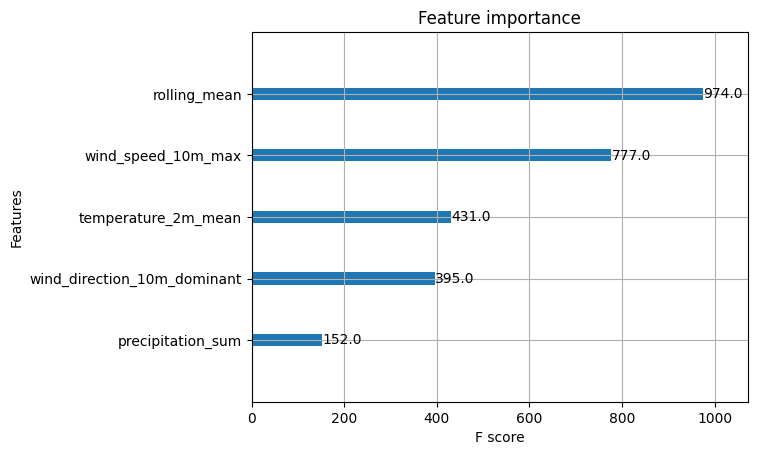

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_poblenou.json: 0.000%| …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_v2.json: 0.000%|          | 0/443…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_parc_vall_dhebron.json:…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model.json: 0.000%|          | 0/452516…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_gracia_st_gervasi.json:…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_palau_reial.json: 0.000…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona.json: 0.000%|          …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_eixample.json: 0.000%| …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_eix…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_pal…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_gra…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_poblenou…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_palau_re…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance.png: 0.000%| …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_gracia_s…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_v2.png: 0.000…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_par…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_pob…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast.png: 0.000%|      …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona.png…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_parc_val…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona.png: 0.0…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_eixample…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_v2.png: 0.000%|   …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279126/models/air_quality_xgboost_barcelona_eixample/12
=== STREET: barcelona-palau-reial ===
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1.0}
MSE: 94.47562
R2: 0.6227066656811051


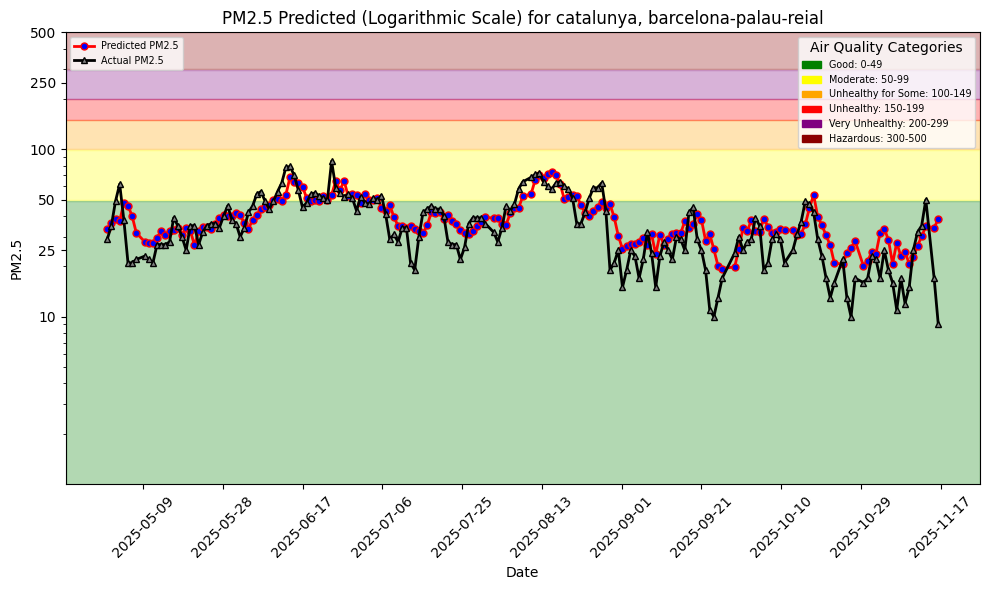

<Figure size 800x600 with 0 Axes>

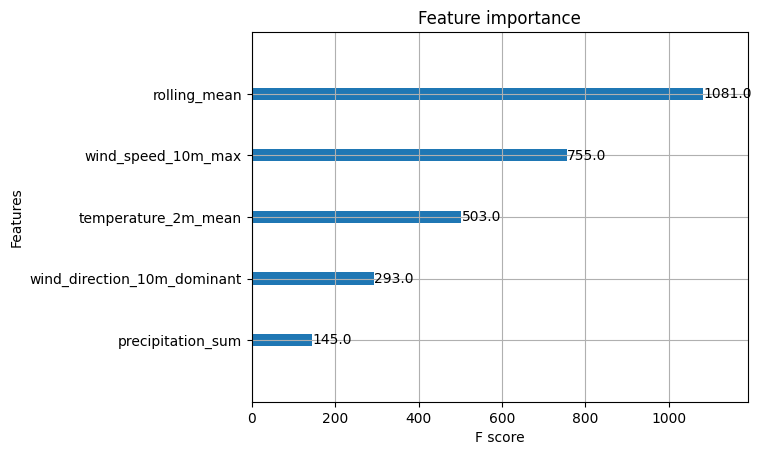

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_poblenou.json: 0.000%| …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_v2.json: 0.000%|          | 0/443…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_parc_vall_dhebron.json:…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model.json: 0.000%|          | 0/452516…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_gracia_st_gervasi.json:…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_palau_reial.json: 0.000…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona.json: 0.000%|          …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_eixample.json: 0.000%| …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_eix…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_pal…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_gra…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_poblenou…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_palau_re…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance.png: 0.000%| …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_gracia_s…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_v2.png: 0.000…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_par…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_pob…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast.png: 0.000%|      …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona.png…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_parc_val…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona.png: 0.0…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_eixample…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_v2.png: 0.000%|   …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279126/models/air_quality_xgboost_barcelona_palau_reial/10
=== STREET: barcelona-poblenou ===
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'subsample': 1.0, 'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 400, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
MSE: 146.617
R2: 0.3348254689118413


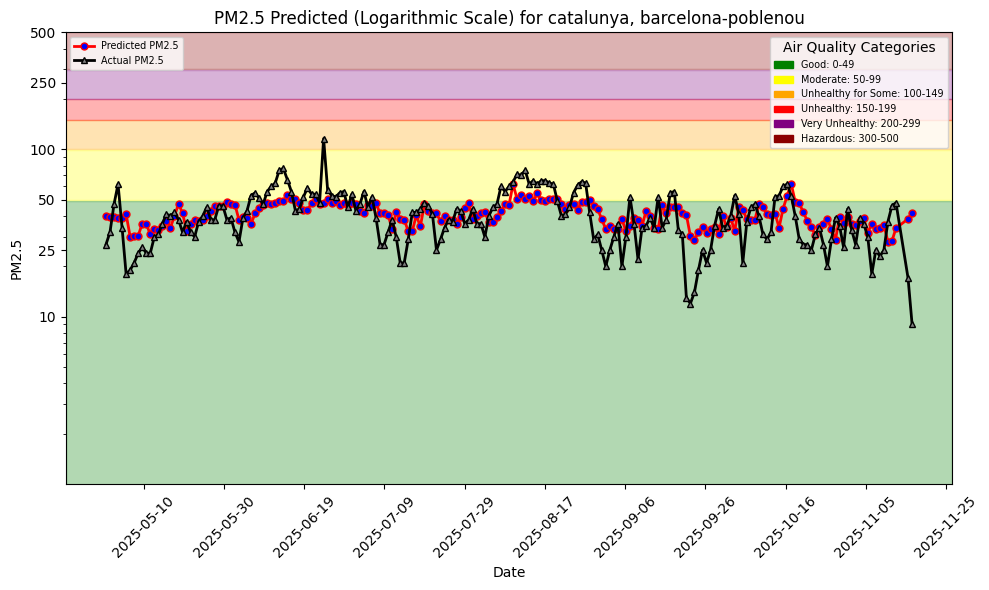

<Figure size 800x600 with 0 Axes>

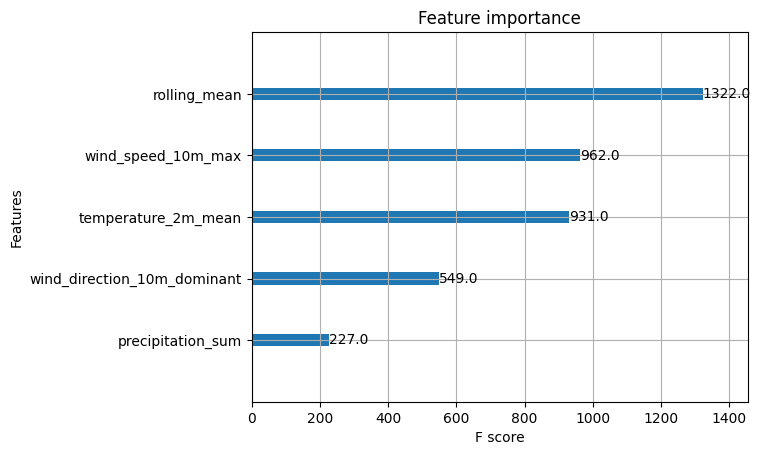

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_poblenou.json: 0.000%| …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_v2.json: 0.000%|          | 0/443…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_parc_vall_dhebron.json:…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model.json: 0.000%|          | 0/452516…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_gracia_st_gervasi.json:…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_palau_reial.json: 0.000…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona.json: 0.000%|          …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/model_barcelona_eixample.json: 0.000%| …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_eix…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_pal…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_gra…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_poblenou…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_palau_re…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance.png: 0.000%| …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_gracia_s…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_v2.png: 0.000…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_par…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona_pob…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast.png: 0.000%|      …

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance_barcelona.png…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_parc_val…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona.png: 0.0…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_barcelona_eixample…

Uploading /home/zohra/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast_v2.png: 0.000%|   …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279126/models/air_quality_xgboost_barcelona_poblenou/10


In [46]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from xgboost import XGBRegressor
import re

streets = selected_features_df["street"].unique()

for s in streets:

    print("=== STREET:", s, "===")

    # Filter dataframe for this street
    df_s = selected_features_df[selected_features_df['street'] == s].copy()
    df_s = df_s.sort_values("date")
    if df_s.empty:
        print("No data — skipping.")
        continue

    # Split manually using your test_start
    train_df = df_s[df_s['date'] < test_start]
    test_df  = df_s[df_s['date'] >= test_start]

    if len(train_df) < 10:
        print("Not enough training data — skipping.")
        continue

    # Prepare features
    X_train = train_df.drop(columns=['pm25', 'date', 'street', 'city'])
    y_train = train_df['pm25']

    X_test = test_df.drop(columns=['pm25', 'date', 'street', 'city'])
    y_test = test_df['pm25']

    # CV adapted to sample count
    n_splits = min(5, len(X_train) - 1)
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Define model
    model = XGBRegressor(
        objective="reg:squarederror",
        n_jobs=-1,
        random_state=42
    )
    param_dist = {
        "n_estimators": [400, 600, 800, 1200],
        "max_depth": [3, 4, 5, 6, 8],
        "learning_rate": [0.01, 0.02, 0.05],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "min_child_weight": [1, 3, 5, 10],
        "gamma": [0, 0.1, 0.2, 0.3],
        "reg_lambda": [1, 2, 5, 10],
        "reg_alpha": [0, 0.1, 0.5, 1.0],
    }

    # Hyperparam search
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=40,
        scoring="neg_root_mean_squared_error",
        cv=tscv,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    search.fit(X_train, y_train)

    print("Best params:", search.best_params_)

    best_model = search.best_estimator_

    # Evaluate
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)
    print("MSE:", mse)
    print("R2:", r2)
    df_plot = test_df[['date', 'pm25', 'city', 'street']].copy()
    df_plot['predicted_pm25'] = y_pred
    df_plot = df_plot.sort_values('date')
    model_dir = "air_quality_model"
    images_dir = os.path.join(model_dir, "images")
    os.makedirs(images_dir, exist_ok=True)
    safe_street = re.sub(r"[^A-Za-z0-9]+", "_", s)
    file_path = os.path.join(images_dir, f"pm25_hindcast_{safe_street}.png")
    city = df_plot['city'].iloc[0]
    plt = util.plot_air_quality_forecast(city, s, df_plot, file_path, hindcast=True)
    plt.show()
    plt.figure(figsize=(8, 6))
    plot_importance(best_model, max_num_features=20)
    
    safe_street = re.sub(r"[^A-Za-z0-9]+", "_", s)
    feature_importance_path = os.path.join(images_dir, f"feature_importance_{safe_street}.png")
    
    plt.savefig(feature_importance_path, bbox_inches="tight")
    plt.show()
    # Save model to registry
    model_name = "air_quality_xgboost_" + re.sub(r"[^A-Za-z0-9]+","_", s)
    best_model.save_model(model_dir + f"/model_{safe_street}.json") 
    
    mr = project.get_model_registry()

    aq_model = mr.python.create_model(
        name=model_name,
        metrics={"MSE":str(mse), "R2":str(r2)},
        description=f"PM25 model for street {s}",
    )

    aq_model.save(model_dir)


---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
